# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
# from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [3]:
# Load data
df = pd.read_csv('btc_open.csv')
print(df)
name_col='open'

      Unnamed: 0 formatted_date          high           low          open  \
0              0     2019-01-01   3850.913818   3707.231201   3849.216309   
1              1     2019-01-02   3947.981201   3817.409424   3931.048584   
2              2     2019-01-03   3935.685059   3826.222900   3832.040039   
3              3     2019-01-04   3865.934570   3783.853760   3851.973877   
4              4     2019-01-05   3904.903076   3836.900146   3836.519043   
...          ...            ...           ...           ...           ...   
1515        1515     2023-02-24  24103.705078  23007.072266  23200.125000   
1516        1516     2023-02-25  23210.210938  22861.558594  23174.150391   
1517        1517     2023-02-26  23654.367188  23084.220703  23561.451172   
1518        1518     2023-02-27  23857.890625  23205.878906  23521.837891   
1519        1519     2023-02-28  23585.384766  23077.650391  23150.929688   

             close       volume      adjclose  
0      3843.520020   432420

In [4]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df[name_col].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df[name_col].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df[name_col].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df[name_col].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df[name_col].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv(f"../../predict/bitcoin_df_{name_col}.csv")
df.set_index('formatted_date')
df2=df.copy()

## Nạp dữ liệu từ file csv

In [5]:

split_x = df2[['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}','formatted_date']]
split_y = df2[[name_col]]

X_train, X_test,y_train, y_test = train_test_split(split_x,split_y ,
                                   random_state=104, 
                                   test_size=0.3, 
                                   shuffle=True)

## Chuẩn hóa dữ liệu

In [6]:
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = [name_col]
x_train = X_train[cols_x].values.reshape(-1, len(cols_x))
y_train = y_train[cols_y].values.reshape(-1, len(cols_y))
print(x_train.shape, y_train.shape)

(1050, 9) (1050, 1)


In [7]:

x_test = X_test[cols_x].values.reshape(-1, len(cols_x))
y_test = y_test[cols_y].values.reshape(-1, len(cols_y))
print(x_test.shape, y_test.shape)

(450, 9) (450, 1)


# 2. Quá trình dự đoán trên mô hình 


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
_gdm = ('gradient', GradientBoostingRegressor(learning_rate= 0.07, max_depth= 8, n_estimators= 1000, subsample= 0.3));
_elm = ('elasticnet', ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True));
_lsm = ('lasso', Lasso(alpha= 3.17, copy_X= True, fit_intercept= False, max_iter= 1, normalize= True, positive= False, precompute= False, random_state= None, selection= 'random', tol= 0.3, warm_start= False));
_ridge = ('ridge',Ridge(alpha= 0.0006, copy_X= True, fit_intercept= False, max_iter= 1, normalize= False, positive= True, random_state= None, solver= 'auto', tol= 0.001));
_lr = ('linear',LinearRegression())

In [10]:
from itertools import permutations 
perm = permutations([_lr, _gdm, _lsm, _ridge]) 
_estimator_elm = []
for i in list(perm): 
    _estimator_elm.append(i)

In [11]:
parameters = {'estimators':_estimator_elm,  
              'final_estimator':_elm}
elm_grid = GridSearchCV(StackingRegressor(estimators= None, final_estimator = None),parameters, scoring='r2', cv=None).fit(x_train, y_train.reshape(-1, 1))
print(elm_grid.best_params_)
elm_reg = StackingRegressor(estimators= elm_grid.best_params_["estimators"], final_estimator = elm_grid.best_params_["final_estimator"])
elm_reg.fit(x_train, y_train.reshape(-1, 1))
elm_pred = elm_reg.predict(x_test)

{'estimators': (('lasso', Lasso(alpha=3.17, fit_intercept=False, max_iter=1, normalize=True,
      selection='random', tol=0.3)), ('ridge', Ridge(alpha=0.0006, fit_intercept=False, max_iter=1, normalize=False,
      positive=True)), ('linear', LinearRegression()), ('gradient', GradientBoostingRegressor(learning_rate=0.07, max_depth=8, n_estimators=1000,
                          subsample=0.3))), 'final_estimator': ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)}


,high,low,close,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21,formatted_date,predict
517,10199.565430,9450.899414,10167.268555,748.666016,9473.754325,9338.408831,9364.745722,412.095874,362.128831,2020-06-01,10159.375563
987,47218.125000,44752.332031,47092.492188,2465.792969,45766.162946,47833.119141,47928.745908,818.779241,2155.433655,2021-09-14,47127.628183
1146,40119.890625,38112.812500,38431.378906,2007.078125,41460.183036,42349.845145,41407.941220,2274.193798,2393.427744,2022-02-20,38439.233511
610,11964.823242,11290.793945,11414.034180,674.029297,11591.386021,11612.334542,11708.603051,214.534879,227.497641,2020-09-02,11418.773050
1470,17484.720703,17162.990234,17446.292969,321.730469,17048.501395,16834.236607,16830.941034,215.487874,219.434221,2023-01-10,17448.553650


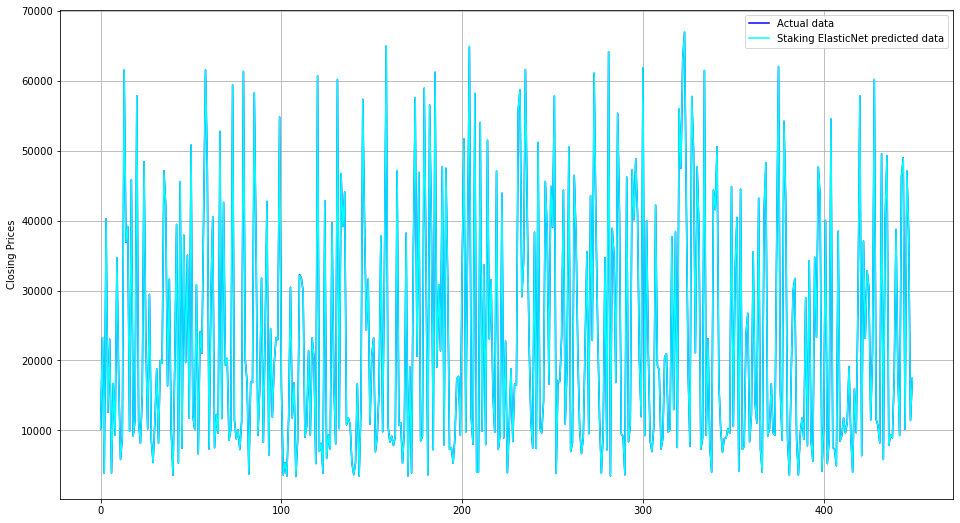

In [12]:

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(y_test, 'blue', label='Actual data')
plt.plot(elm_pred, 'cyan', label='Staking ElasticNet predicted data')
plt.legend()
X_test['predict']=elm_pred
X_test.tail()

In [13]:
mae = mean_absolute_error(y_test, elm_pred)
mape = mean_absolute_percentage_error(y_test, elm_pred)
mse = mean_squared_error(y_test, elm_pred)
rmse = np.sqrt(mse)
# r2 = r2_score(y_test, elm_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
# print(f"R2: {r2:.2f}")

MAE: 16.01
MAPE: 0.07%
MSE: 730.24
RMSE: 27.02
